In [1]:
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat 
import matplotlib.pyplot as plt

In [2]:
eeg= loadmat('F:/SEED_IV/eeg_raw_data/1/1_20160518.mat')  #：15个被试（选一个）
eeg1=eeg['cz_eeg1']                                       #：24个片段(选一个)
eeg11=eeg1[0,:]                                           #：61个电极（选一个）
print(eeg11.shape)                                        #：时间序列特征（500）

(33601,)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [4]:
class EEGDataset(Dataset):
    def __init__(self):
        pass
    def __getitem__(self, index):
        for index in range(50):
            r = random.randint(0,100)
            x = torch.Tensor(eeg11[index:index+500])
            x = x.unsqueeze(1)
            y = torch.Tensor(eeg11[r:r+500])
            y = y.unsqueeze(1)
            index +=1
        return x, y
    def __len__(self):
        return 50

dataset=EEGDataset()    

In [5]:
dataloader = DataLoader(dataset,batch_size=10,shuffle=True)

In [6]:
class eeglstm(nn.Module):
    def __init__(self):
        super(eeglstm,self).__init__()
        # 
        self.lstm = nn.LSTM(1, 256, 2, batch_first=True)  #（input,hidden,layer）
        self.mlp = nn.Sequential(
            nn.Linear(256, 512),
            nn.Linear(512,128),
            nn.Linear(128,64)
        )
    def forward(self, x):
        h0 = torch.zeros(2,10, 256).to(device)
        c0 = torch.zeros(2,10, 256).to(device)
        # print(x.shape)       ##(batch_size，sqe_len，input_size)
        x, _ = self.lstm(x, (h0, c0))
        x = self.mlp(x)
        x = x.view(-1)
        # y, _ = self.lstm(y, (h0, c0))
        # y = self.mlp(y)
        # y = y.view(-1)
        return x
model = eeglstm()

In [7]:
import math

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.CosineSimilarity(dim=-1, eps=1e-6)
loss_list = []
cos_sim_list = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(50):
    print('epoch:\t',epoch)
    for data in dataloader:
        x,y = data 
        x = x.to(device)
        y = y.to(device)
        zx = model(x)
        zy = model(y)
        cos_sim = loss_fn(zx,zy)  # 计算相似度
        loss = -cos_sim.mean()    # 最大化相似度
        loss.backward()        # 反向传播
        optimizer.step()       # 更新参数
        optimizer.zero_grad()  # 梯度清空
        loss = loss.cpu()
        loss = loss.detach().numpy()
        # loss = math.fabs(loss)
        loss_list.append(loss)
        cos_sim = cos_sim.cpu()
        cos_sim = cos_sim.detach().numpy()
        cos_sim_list.append(cos_sim)
        

epoch:	 0
epoch:	 1
epoch:	 2
epoch:	 3
epoch:	 4
epoch:	 5
epoch:	 6
epoch:	 7
epoch:	 8
epoch:	 9
epoch:	 10
epoch:	 11
epoch:	 12
epoch:	 13
epoch:	 14
epoch:	 15
epoch:	 16
epoch:	 17
epoch:	 18
epoch:	 19
epoch:	 20
epoch:	 21
epoch:	 22
epoch:	 23
epoch:	 24
epoch:	 25
epoch:	 26
epoch:	 27
epoch:	 28
epoch:	 29
epoch:	 30
epoch:	 31
epoch:	 32
epoch:	 33
epoch:	 34
epoch:	 35
epoch:	 36
epoch:	 37
epoch:	 38
epoch:	 39
epoch:	 40
epoch:	 41
epoch:	 42
epoch:	 43
epoch:	 44
epoch:	 45
epoch:	 46
epoch:	 47
epoch:	 48
epoch:	 49


In [9]:
loss_list= np.array(loss_list)
cos_sim_list = np.array(cos_sim_list)

In [10]:
type(cos_sim_list)
print(cos_sim_list)
print(cos_sim_list.shape)

[0.98335004 0.93728673 0.9913561  0.99412817 0.9971517  0.99781585
 0.99859226 0.9984989  0.9986855  0.9989854  0.99881333 0.9993449
 0.9994425  0.9995233  0.99968123 0.9996156  0.9997293  0.9997658
 0.99985355 0.9997867  0.9998404  0.99986017 0.99991715 0.9998597
 0.99984956 0.9998853  0.9999084  0.9999008  0.99993974 0.9999521
 0.99994093 0.99995506 0.99995226 0.9999523  0.99996257 0.9999607
 0.99996555 0.99996877 0.9999625  0.9999652  0.999973   0.9999746
 0.9999797  0.99998105 0.9999797  0.9999795  0.9999796  0.9999862
 0.9999844  0.9999825  0.9999871  0.99998647 0.99998724 0.99998856
 0.99998945 0.99999106 0.9999884  0.9999914  0.9999924  0.9999913
 0.9999914  0.9999926  0.99999404 0.9999933  0.9999935  0.9999934
 0.99999344 0.99999285 0.99999404 0.99999446 0.9999935  0.99999446
 0.99999475 0.99999523 0.99999535 0.99999535 0.9999958  0.9999951
 0.99999535 0.99999565 0.99999547 0.99999505 0.9999968  0.9999955
 0.9999961  0.99999535 0.9999958  0.99999577 0.9999962  0.9999957
 0.9999

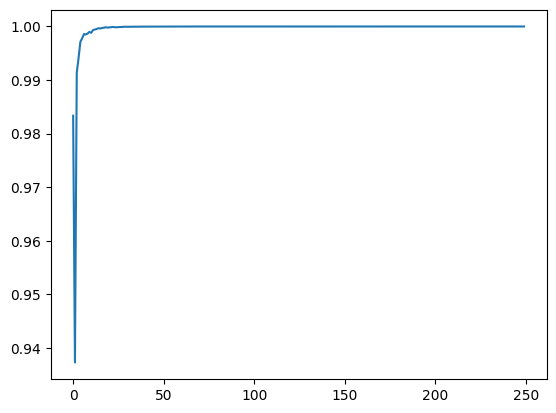

In [11]:
plt.plot(cos_sim_list)
# plt.plot(loss_list)
plt.show()